# 라이브러리 설치

In [ ]:
! pip install transformers
! pip install sentencepiece
! pip install tensorflow

# 라이브러리

In [1]:
from transformers import BertTokenizer, TFBertModel
from transformers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
import tensorflow as tf
import os
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

# 함수 및 Class 모음

In [10]:
# 시각화
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()


# BERT Tokenizer 작업에 필요한 구조 만드는 함수
# 1. 특정 문장을 BERT에 필요한 입력 형태로 변환
# 2. 문장 최대 길이에 맞게 패딩 처리
# 3. 딕셔너리로 반환
def bert_tokenizer(sent, MAX_LEN, tokenizer):

    # 위에서 불러온 tokenizer 사용
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # ==> 토큰의 시작점을 '[CLS]' , 토큰 마지막에는 '[SEP]' 토큰들을 추가해준다
        max_length = MAX_LEN, 
        pad_to_max_length = True,  # 최대 길이보다 넘어가는 것 padding 처리하기 위한 설정
        return_attention_mask = True # attention mask 생성한다
    )

    # input_ids : 문장을 토크나이즈 한 후 index로 변화 (Word Piece Tokenizer 사용 )
    # Word Piece Tokenizer 란 단어를 subword의 단위로 변환시키는...
    input_ID = encoded_dict['input_ids']
    
    # attention mask : 패딩된 부분이 학습에 영향 미치지 못하도록 처리해주는 입력값. 버트 토크나이저에서 0은 어텐션에 영향 받지 않는 토큰, 1은 영향 받는 토큰
    attention_mask = encoded_dict['attention_mask']

    token_type_id = encoded_dict['token_type_ids'] # ==> 2개의 문장을 분리하기 위해서

    return input_ID, attention_mask, token_type_id


# 전처리 함수
def clean_text(text):
    result = re.sub(r'[^가-힣]', ' ', str(text))
    return result


# 학습을 위한 BERT 분류 class
# 사전 학습된 bert 모델을 불러온 후 fully connected layer 1개를 쌓는 구조
class TFBertClassifier(tf.keras.Model):

    # model_name : 활용할 모델 이름
    # dir_path : 모델이 저장된 위치
    # num_class : 클래스의 수
    def __init__(self, model_name, dir_path, num_class):
        super(TFBertClassifier, self).__init__()

        # 기존 학습된 모델 load
        # TFBertModel의 결과값은 sequence_output, pooled_output, hidden_states, attentions 로 구성
        self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        self.classifier = tf.keras.layers.Dense(num_class, # ==> label의 개수 : binary는 2개
                                                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                name='classifier')

    # 입력 받고 실행 함수
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        # outputs 값 : sequence_output, pooled_output, (hidden_states), (attentions)
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)

        # 마지막 출력에 완전연결층 1층 적용
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)

        return logits

In [ ]:
# bert의 입력값 요약

# input_ids : 문장을 토크나이즈 한 후 index로 변화 (Word Piece Tokenizer 사용 )
# Word Piece Tokenizer 란 단어를 subword의 단위로 변환시키는...

# attention mask : 패딘된 부분이 학습에 영향 미치지 못하도록 처리해주는 입력값. 버트 토크나이저에서 0은 어텐션에 영향 받지 않는 토큰, 1은 영향 받는 토큰

# token_type_idx : 두 개의 시퀀스를 입력으로 사용할 때 0과 1로 토큰 값을 분리한다.

# special token
# [UNK] : 모르는 단어에 대한 토큰
# [MASK] : 사전 학습에서 사용하는 마스크 토큰
# [PAD] : 최대 길이를 맞춰주는 토큰
# [SEP] : 문장의 종결을 알려주는 토큰
# [CLS] : 문장의 시작을 알려주는 토큰

# BERT에 입력하기 위해서는 이에 맞는 입력값의 형태로 변환해야한다.
# 변환하는 구조를 허깅페이스의 Tokenizer(http://github.com/huggingface/tokenizers) 라이브러리 활용 예정

# 허깅페이스의 Tokenizer 특징
# 1. CPU에 최적화 돼 있음
# 2. 20초 이내에 GB 단위의 문장을 토크나이징 할 수 있음

# BertTokenizer

In [3]:
# Bert의 다국어 Tokenizer를 활용하여 기존 학습한 모델과 동일하게 전처리 해줘야 한다
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', cach_dir='bert_ckpt', do_lower_case=False)

In [ ]:
# BERT 입력을 위한 토크나이저로 학습할 데이터를 전처리 해야 한다.
# 우선 tokenizer가 잘 작동하는 지 확인해보자

print(tokenizer.all_special_tokens, '\n', tokenizer.all_special_ids)
'''
['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]
'''

# test tokenizer
# encoding
kor_encode = tokenizer.encode('안녕하세요. 만나서 반갑습니다.')
eng_encode = tokenizer.encode('Hello. Nice to meet you.')
# decoding
kor_decode = tokenizer.decode(kor_encode)
eng_decode = tokenizer.decode(eng_encode)

print(kor_encode)
# ==> [101, 9521, 118741, 35506, 24982, 48549, 119, 9248, 16439, 12424, 9321, 118610, 119081, 48345, 119, 102]
print(kor_decode)
# ==> [CLS] 안녕하세요. 만나서 반갑습니다. [SEP]
print(eng_encode)
# ==> [101, 31178, 119, 26918, 10114, 23267, 13028, 119, 102]
print(eng_decode)
# ==> [CLS] Hello. Nice to meet you. [SEP]


# Data Load

In [ ]:
# 자소서 텍스트 불러오기
pd.set_option('max_row', 6)
df = pd.read_excel('./히든그레이스_자소서_텍스트분석_data.xlsx')
for idx, col in enumerate(df.columns):
    print(idx, col)

In [ ]:
# 지원동기 텍스트로만 test
use_df = df.iloc[:,[0,24,17]]
use_df['지원동기 및 입사 후 포부'] = use_df['지원동기 및 입사 후 포부'].map(clean_text)
use_df['len'] = use_df['지원동기 및 입사 후 포부'].map(lambda x : len(x))
#use_df

In [27]:
use_df['len'].describe()

count      80.000000
mean      349.637500
std       299.125275
            ...     
50%       297.500000
75%       520.250000
max      1416.000000
Name: len, Length: 8, dtype: float64

# Bert Input format change

In [14]:
# 버트 토크나이저 활용
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

# 2사분위 기준
MAX_LEN = int(np.percentile(use_df['len'], 50))

for train_data, train_label in zip(use_df['지원동기 및 입사 후 포부'].values, use_df['label2'].values):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_data, MAX_LEN, tokenizer)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e :
        print(e)
        print(train_data)
        pass

# 각 값들을 넘파이 배열로 전환하고
train_input_ids = np.array(input_ids, dtype=int)
train_attention_masks = np.array(attention_masks, dtype=int)
train_type_ids = np.array(token_type_ids, dtype=int)

# input 데이터를 튜플로 하나로 묶음
train_inputs = train_input_ids, train_attention_masks, train_type_ids

# label 토크나이징 리스트
train_labels = np.asarray(train_data_labels, dtype=np.int32)

In [ ]:
# test 
sample_input_id = train_input_ids[0]
sample_attention_mask = train_attention_masks[0]
sample_token_type_id = train_type_ids[0]

print(sample_input_id)
print(sample_attention_mask)
print(sample_token_type_id)
print()
print(tokenizer.decode(sample_input_id))

# Bert 분류 모델

In [ ]:
cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert_ckpt',
                             num_class=2)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # ==> 정수형태로 정답 출력 (원-핫 형태는 CategoricalCrossentropy)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

cls_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

# 학습할 파라미터가 많아서 GPU 사용해야 한다
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=2)

DATA_OUT_PATH = './model'
model_name = 'pretrained_bert'
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    print(f'{checkpoint_dir} -- Folder already exists \n')
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print(f'{checkpoint_dir} -- Folder created complete')

cp_callback = ModelCheckpoint(
    checkpoint_path, 
    monitor='val_accuracy', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
    )

cls_model_name = 'pretrainde_bert_cls'
BATCH_SIZE = 8
NUM_EPOCHS = 4
VALID_SPLIT = 0.1

history = cls_model.fit(
    train_inputs,
    train_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split = VALID_SPLIT,
    #callbacks=[cp_callback]
)

# 모델 결과 그래프

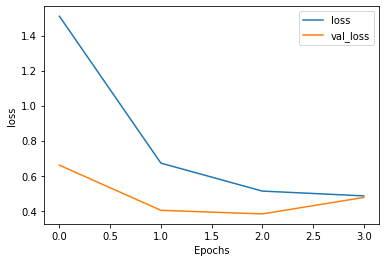

In [23]:
plot_graphs(history, 'loss')

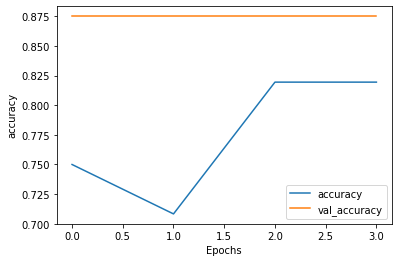

In [24]:
plot_graphs(history, 'accuracy')

# 모델 가중치 저장

In [25]:
cls_model.save_weights('weights', save_format='h5')

# 모델 가중치 불러와서 적용 시도

In [ ]:
new_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                             dir_path='bert_ckpt',
                             num_class=2)

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True) # ==> 정수형태로 정답 출력 (원-핫 형태는 CategoricalCrossentropy)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

new_model.compile(optimizer=optimizer,
                  loss=loss,
                  metrics=[metric])

BATCH_SIZE = 8
NUM_EPOCHS = 3
VALID_SPLIT = 0.1

new_history = new_model.fit(
    train_inputs,
    train_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split = VALID_SPLIT,
    #callbacks=[cp_callback]
)
new_model.load_weights('weights.h5')

In [32]:
new_history = new_model.fit(
    train_inputs,
    train_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split = VALID_SPLIT,
    #callbacks=[cp_callback]
)

9/9 [==============================] - 101s 11s/step - loss: 0.5925 - accuracy: 0.7778 - val_loss: 0.4098 - val_accuracy: 0.8750


In [35]:
new_history.history

{'loss': [0.5925184488296509],
 'accuracy': [0.7777777910232544],
 'val_loss': [0.4097636640071869],
 'val_accuracy': [0.875]}